1. Data Cleaning and Pre-processing
    *   Statistical transformation 
    *   Dealing with Special Cases 
    *   Dealing with NA's
    *   Delete Outliers 
2. Modeling


**Module Imports**

In [223]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso, Ridge
from xgboost.sklearn import  XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Any results you write to the current directory are saved as output.

**Load Data**

In [224]:
#Data reading
train = pd.read_csv("../input/train.csv")
test  = pd.read_csv("../input/test.csv")

print("Train set size:", train.shape)
print("Test set size:", test.shape)

train.head(5)

Train set size: (1460, 81)
Test set size: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


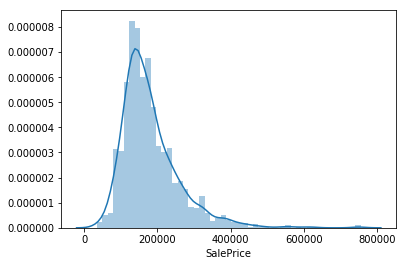

In [225]:
sns.distplot(train.SalePrice)

It turns out there is a long tail of outlying properties with high sale prices, which biases the mean to be much higher than the median. We can correct this with a simple log transformation.

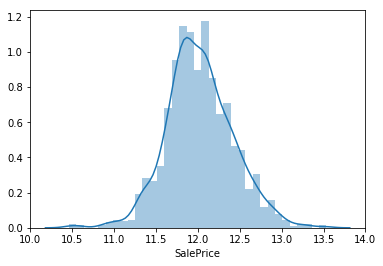

In [226]:
sns.distplot(np.log(train.SalePrice + 1))

all_data = pd.concat((train.drop(["SalePrice"], axis=1), test))

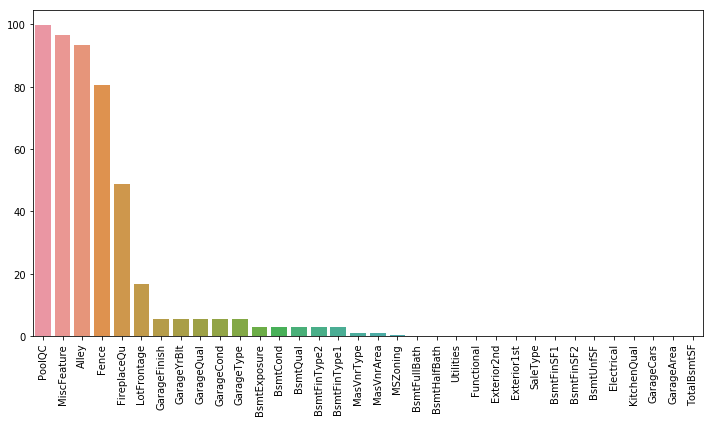

In [227]:
#Data Visulization for missing values
all_data = pd.concat((train.drop(["SalePrice"], axis=1), test))
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.xticks(rotation="90")
sns.barplot(x=all_data_na.index, y=all_data_na)

PoolQC(Pool quality) 

In [228]:
all_data = pd.concat((train.drop(["SalePrice"], axis=1), test))

Most of "PoolQC"can be filled with 'None'. However, there're three exceptions. 
When PoolQC is missing the PoolArea should be 0. However, there are three NaN's foor PoolQC that have a PoolArea. Let's impute them based on overall quality of the house.

In [229]:
train = train.fillna({"PoolQC": "None"})
test = test.fillna({"PoolQC": "None"})

all_data[all_data.PoolArea != 0][["PoolArea", "PoolQC"]]

,PoolArea,PoolQC
197,512,Ex
810,648,Fa
1170,576,Gd
1182,555,Ex
1298,480,Gd
1386,519,Fa
1423,738,Gd
514,144,Ex
960,368,NaN
1043,444,NaN


In [230]:
test.loc[960, "PoolQC"] = "Fa"
test.loc[1043, "PoolQC"] = "Gd"
test.loc[1139, "PoolQC"] = "Fa"

Special cases for Garage Type. Most of the Garage tpes can be filled with none. We fill some special cases with mode.

In [231]:
# Garage
test.loc[666, "GarageYrBlt"] = 1979
test.loc[1116, "GarageYrBlt"] = 1979

test.loc[666, "GarageFinish"] = "Unf"
test.loc[1116, "GarageFinish"] = "Unf"

test.loc[1116, "GarageCars"] = 2
test.loc[1116, "GarageArea"] = 480

test.loc[666, "GarageQual"] = "TA"
test.loc[1116, "GarageQual"] = "TA"

test.loc[666, "GarageCond"] = "TA"
test.loc[1116, "GarageCond"] = "TA"

fill with 'none' or 0

In [232]:
# MiscFeature,Fence,Utilities, Exterior2nd,LandSlope
train = train.drop(["Fence", "MiscFeature", "Utilities", 'Street'], axis=1)
test = test.drop(["Fence", "MiscFeature", "Utilities", 'Street'], axis=1)
train = train.drop(["LandSlope", "Exterior2nd"], axis=1)
test = test.drop(["LandSlope", "Exterior2nd"], axis=1)

# Alley
train = train.fillna({"Alley": "None"})
test = test.fillna({"Alley": "None"})

# FireplaceQu
train = train.fillna({"FireplaceQu": "None"})
test = test.fillna({"FireplaceQu": "None"})

# LotFrontage
train = train.fillna({"LotFrontage": 0})
test = test.fillna({"LotFrontage": 0})

# Garage
train = train.fillna({"GarageType": "None"})
test = test.fillna({"GarageType": "None"})
train = train.fillna({"GarageYrBlt": 0})
test = test.fillna({"GarageYrBlt": 0})
train = train.fillna({"GarageFinish": "None"})
test = test.fillna({"GarageFinish": "None"})
test = test.fillna({"GarageCars": 0})
test = test.fillna({"GarageArea": 0})
train = train.fillna({"GarageQual": "None"})
test = test.fillna({"GarageQual": "None"})
train = train.fillna({"GarageCond": "None"})
test = test.fillna({"GarageCond": "None"})

# Bsmt
train = train.fillna({"BsmtQual": "None"})
test = test.fillna({"BsmtQual": "None"})
train = train.fillna({"BsmtCond": "None"})
test = test.fillna({"BsmtCond": "None"})
train = train.fillna({"BsmtExposure": "None"})
test = test.fillna({"BsmtExposure": "None"})
train = train.fillna({"BsmtFinType1": "None"})
test = test.fillna({"BsmtFinType1": "None"})
train = train.fillna({"BsmtFinSF1": 0})
test = test.fillna({"BsmtFinSF1": 0})
train = train.fillna({"BsmtFinType2": "None"})
test = test.fillna({"BsmtFinType2": "None"})
test = test.fillna({"BsmtFinSF2": 0})
test = test.fillna({"BsmtUnfSF": 0})
test = test.fillna({"TotalBsmtSF": 0})
test = test.fillna({"BsmtFullBath": 0})
test = test.fillna({"BsmtHalfBath": 0})

# MasVnr
train = train.fillna({"MasVnrType": "None"})
test = test.fillna({"MasVnrType": "None"})
train = train.fillna({"MasVnrArea": 0})
test = test.fillna({"MasVnrArea": 0})





Some exceptions:

Functional: The documentation says that we should assume "Typ", so lets impute that.

Electrical: The documentation doesn't give any information but obviously every house has this so let's impute the most common value: "SBrkr".

KitchenQual: Similar to Electrical, most common value: "TA".

Exterior 1 and Exterior 2: Let's use the most common one here.

SaleType: Similar to electrical, let's use most common value.

In [233]:
# other
test = test.fillna({"MSZoning": "RL"})
test = test.fillna({"Exterior1st": "VinylSd"})
test = test.fillna({"Exterior2nd": "VinylSd"})
train = train.fillna({"Electrical": "SBrkr"})
test = test.fillna({"KitchenQual": "TA"})
test = test.fillna({"Functional": "Typ"})
test = test.fillna({"SaleType": "WD"})

Now we're just left with a handful of remaining features/properties that have NaN values. 
All of them happen to be categorical variables, and I just replace the missing values with the mode for that feature. Most of the remaining NaNs are in the test dataset, otherwise I might have just deleted them.



In [234]:
features_mode = {}
for f in test:
    f,':', list(test[f].dropna().mode().values)
    features_mode[f] = list(test[f].dropna().mode().values)[0]
test.fillna(features_mode,inplace=True)

In [235]:
train.isnull().sum().sum()
test.isnull().sum().sum()

0

In [236]:

train_dummies = pd.get_dummies(
    pd.concat((train.drop(["SalePrice","Id"], axis=1), test.drop(["Id"], axis=1)), axis=0)).iloc[: train.shape[0]]

test_dummies = pd.get_dummies(
    pd.concat((train.drop(["SalePrice","Id"], axis=1), test.drop(["Id"], axis=1)), axis=0)).iloc[train.shape[0]:]


y = train["SalePrice"]
y = np.log(y + 1)

**Remove Outliers**

Now time to start fitting some models! First I fit a linear regression Ridge model, because it immediately gives good results with default values. My goal here is to use a straightforward model to identify any outlying points - properties with sale prices far away from what's expected given their features.

The function I define below fits the model and checks the residuals between the model's predicted sale prices and the true sale prices. The standard deviation of the residuals is calculated, and the 20 or so properties with residuals greater than three times this standard deviation are removed from the training data so they don't skew the parameters of the fitted models.

Just Ridge with default values already gives a decent prediction, which is a promising sign.

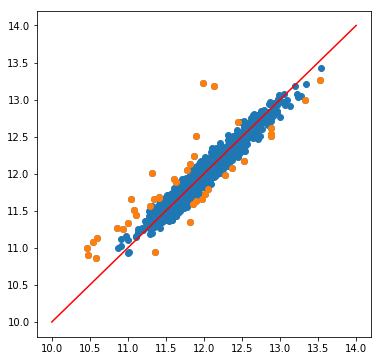

In [237]:
rr = Ridge(alpha=10)
rr.fit(train_dummies, y)
np.sqrt(-cross_val_score(rr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

y_pred = rr.predict(train_dummies)
resid = y - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
z = (resid - mean_resid) / std_resid
z = np.array(z)
outliers1 = np.where(abs(z) > abs(z).std() * 3)[0]

plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred)
plt.scatter(y.iloc[outliers1], y_pred[outliers1])
plt.plot(range(10, 15), range(10, 15), color="red")





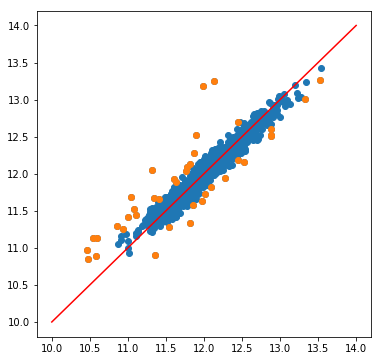

In [238]:
er = ElasticNet(alpha=0.001, l1_ratio=0.58)
er.fit(train_dummies, y)
np.sqrt(-cross_val_score(rr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

y_pred = er.predict(train_dummies)
resid = y - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
z = (resid - mean_resid) / std_resid
z = np.array(z)
outliers2 = np.where(abs(z) > abs(z).std() * 3)[0]

plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred)
plt.scatter(y.iloc[outliers2], y_pred[outliers2])
plt.plot(range(10, 15), range(10, 15), color="red")

Find outliers from these two modles

In [239]:
outliers = []
for i in outliers1:
    for j in outliers2:
        if i == j:
            outliers.append(i)
outliers

[30,
 88,
 142,
 277,
 328,
 410,
 438,
 462,
 495,
 523,
 533,
 581,
 588,
 628,
 632,
 681,
 688,
 710,
 714,
 728,
 774,
 812,
 874,
 898,
 916,
 968,
 970,
 1181,
 1182,
 1298,
 1324,
 1383,
 1423,
 1432,
 1453]

Delete outliers

In [240]:
train = train.drop(
    [30, 88, 410, 462, 495, 523, 588, 628, 632, 874, 898, 968, 970, 1182, 1298, 1324, 1432])

**Modeling**

In [241]:
#dummies
train_dummies = pd.get_dummies(pd.concat((train.drop(["SalePrice","Id"], axis=1), test.drop(["Id"], axis=1)), axis=0)).iloc[: train.shape[0]]
test_dummies = pd.get_dummies(pd.concat((train.drop(["SalePrice","Id"], axis=1), test.drop(["Id"], axis=1)), axis=0)).iloc[train.shape[0]:]

y = train["SalePrice"]
y = np.log(y + 1)

GBDT

In [242]:
gbr = GradientBoostingRegressor(max_depth=4, n_estimators=150)
gbr.fit(train_dummies, y)
print(np.sqrt(-cross_val_score(gbr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean())

0.10760341649750904


XGB

In [243]:
xgbr = XGBRegressor(max_depth=5, n_estimators=400)
xgbr.fit(train_dummies, y)
print(np.sqrt(-cross_val_score(xgbr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean())

[05:20:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:21:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:21:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:21:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:21:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: 

Lasso

In [ ]:
lsr = Lasso(alpha=0.00047)
lsr.fit(train_dummies, y)
print(np.sqrt(-cross_val_score(lsr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean())

Ridge

In [ ]:
rr = Ridge(alpha=13)
rr.fit(train_dummies, y)
np.sqrt(-cross_val_score(rr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

Model

In [ ]:
train_predict = 0.1 * gbr.predict(train_dummies) + 0.3 * xgbr.predict(train_dummies) + 0.3 * lsr.predict(train_dummies) + 0.3 * rr.predict(train_dummies)
                                                                                                                                           
train_predict             

Brutal approach to deal with predictions close to outer range.

In [ ]:
q1 = pd.DataFrame(train_predict).quantile(0.0042)
pre_df = pd.DataFrame(train_predict)
pre_df["SalePrice"] = train_predict
pre_df = pre_df[["SalePrice"]]
pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] = pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] *0.99
train_predict = np.array(pre_df.SalePrice)

In [ ]:
sample_submission = pd.read_csv("../input/sample_submission.csv")
test_predict = 0.1 * gbr.predict(test_dummies) + 0.3 * xgbr.predict(test_dummies) + 0.3 * lsr.predict(test_dummies) + 0.3 * rr.predict(test_dummies)
q1 = pd.DataFrame(test_predict).quantile(0.0042)
pre_df = pd.DataFrame(test_predict)
pre_df["SalePrice"] = test_predict
pre_df = pre_df[["SalePrice"]]
pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] = pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] *0.96
test_predict = np.array(pre_df.SalePrice)


In [ ]:
sample_submission["SalePrice"] = np.exp(test_predict)
sample_submission.to_csv("ssss.csv", index=False)